# 1 - Transfer Learning

<hr>

It can take weeks to train a neural network on large datasets. Luckily, this time can be shortened thanks to model weights from pre-trained models - in other words, applying **transfer learning.**

## 1.1 - What is Transfer Learning?

<font color="red">Transfer learning is about leveraging feature representations from a pre-trained model, so you don't have to train a new model from scratch.</font>

- The pre-trained models are usually trained on massive datasets that are a standard benchmark. The weights obtained from the models can be reused in other similar tasks. 

- These models can be used directly in making predictions on new tasks or integrated into the process of training a new model. Including the pre-trained models in a new model leads to lower training time and lower generalization error.  

- Transfer learning is particularly very useful when you have a small training dataset. In this case, you can, for example, use the weights from the pre-trained models to initialize the weights of the new model.

The advantage of pre-trained models is that they are generic enough for use in other real-world applications. For example:

- **models trained on the ImageNet** can be used in real-world image classification problems. This is because the dataset contains over 1000 classes. Let's say you are an insect researcher. You can use these models and fine-tune them to classify insects. 

- **classifying text requires knowledge of word representations** in some vector space. You can train vector representations yourself. The challenge here is that you might not have enough data to train the embeddings. Furthermore, training will take a long time. In this case, you can use a pre-trained word embedding like `GloVe` to hasten your development process.

## 1.2 - Why use transfer learning?

Assuming you have 100 images of cats and 100 dogs and want to build a model to classify the images. How would you train a model using this small dataset? You can train your model from scratch, but it will most likely overfit horribly. Enter transfer learning. Generally speaking, there are two big reasons why you want to use transfer learning:

- **training models with high accuracy requires a lot of data.** For example, the ImageNet dataset contains over 1 million images. In the real world, you are unlikely to have such a large dataset. 

- assuming that you had that kind of dataset, you might still **not have the resources required to train a model** on such a large dataset. Hence transfer learning makes a lot of sense if you don't have the compute resources needed to train models on huge datasets.

- even if you had the compute resources at your disposal, you still have to **wait for days or weeks to train such a model.** Therefore using a pre-trained model will save you precious time.

## 1.3 - When does transfer learning not work?

Transfer learning will not work when the high-level features learned by the bottom layers are not sufficient to differentiate the classes in your problem. For example, a pre-trained model may be very good at identifying a door but not whether a door is closed or open. In this case, you can use the low-level features (of the pre-trained network) instead of the high-level features. In this case, you will have to retrain more layers of the model or use features from earlier layers. 

When datasets are not similar, features transfer poorly. This [paper](https://arxiv.org/pdf/1411.1792.pdf) investigates the similarity of datasets in more detail. That said, as shown in the paper, initializing the network with pre-trained weights results in better performance than using random weights. 

You might find yourself in a situation where you consider the removal of some layers from the pre-trained model. Transfer learning is unlikely to work in such an event. This is because removing layers reduces the number of trainable parameters, which can result in overfitting. Furthermore, determining the correct number of layers to remove without overfitting is a cumbersome and time-consuming process. 

## 1.4 - How to implement transfer learning?

You can implement transfer learning in these six general steps.

### 1.4.1 - Obtain the pre-trained model
The first step is to get the pre-trained model that you would like to use for your problem.

### 1.4.2 - Create a base model
Usually, the first step is to instantiate the base model using one of the architectures such as `ResNet`. You can also optionally download the pre-trained weights. If you don't download the weights, you will have to use the architecture to train your model from scratch. Recall that the base model will usually have more units in the final output layer than you require. When creating the base model, you, therefore, have to remove the final output layer. Later on, you will add a final output layer that is compatible with your problem. 

### 1.4.3 - Freeze layers so they don't change during training
Freezing the layers from the pre-trained model is vital. This is because you don't want the weights in those layers to be re-initialized. If they are, then you will lose all the learning that has already taken place. This will be no different from training the model from scratch.

### 1.4.4 - Add new trainable layers 
The next step is to add new trainable layers that will turn old features into predictions on the new dataset. This is important because the pre-trained model is loaded without the final output layer. 

### 1.4.5 - Train the new layers on the dataset
Remember that the pre-trained model's final output will most likely be different from the output that you want for your model. For example, pre-trained models trained on the ImageNet dataset will output 1000 classes. However, your model might just have two classes. In this case, you have to train the model with a new output layer in place. Therefore, you will add some new dense layers as you please, but most importantly, a final dense layer with units corresponding to the number of outputs expected by your model. 

### 1.4.6 - Improve the model via fine-tuning
Once you have done the previous step, you will have a model that can make predictions on your dataset. Optionally, you can improve its performance through fine-tuning. Fine-tuning is done by unfreezing the base model or part of it and training the entire model again on the whole dataset at a very low learning rate. The low learning rate will increase the performance of the model on the new dataset while preventing overfitting. The learning rate has to be low because the model is quite large while the dataset is small. This is a recipe for overfitting, hence the low learning rate. Recompile the model once you have made these changes so that they can take effect. This is because the behavior of a model is frozen whenever you call the compile function. That means that you have to call the compile function again whenever you want to change the model's behavior. The next step will be to train the model again while monitoring it via callbacks to ensure it does not overfit.

<font color="purple">Below are 2 renditions of the same notebook to illustrate different factors that affect the learning. Explain where the differences are that make the loss plot different between the two.</font>

[NEU Dataset](https://github.com/smahesh2694/NEU_XAI)

In [1]:
import os
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torchvision.models as models

from torchinfo import summary
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import DatasetFolder

In [2]:
def load_image(img_path):
    np_img = cv2.imread(img_path)
    return Image.fromarray(np_img)

In [3]:
# We need to write a transform to make dataset compatible with resnet18 (size 224x224x3, and type tensor)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [4]:
# NEUdata has 6 folders each containing 300 bmp files
dset = DatasetFolder(root='NEUdata', loader=load_image, extensions=('.bmp',), transform=transform)

In [5]:
len(dset)

1800

In [6]:
train_set, val_set = random_split(dset, [1200, 600])

trainloader = DataLoader(train_set, batch_size=16, shuffle=True)
valloader = DataLoader(val_set, batch_size=16, shuffle=True)

In [7]:
print(len(trainloader))
# out: 1200 / 16 = 75

print(len(valloader))
# out: 600 / 16 = 37.5

75
38


# 2 - Transfer Learning with `resnet18`

<hr>

### 2.1 - Approach 1

- Utilizing ResNet-18 architecture **without pre-trained weights:**
    - Training from scratch, no prior knowledge from pre-trained weights.
    - Potentially higher initial error due to learning all features and weights without a starting base.

- Employing a `LinearLR` scheduler for learning rate adjustment:
    - Adjusts learning rate linearly from a start to an end factor over specified iterations.
    - Aims for a balance between rapid learning and precise model convergence.
    - Enhances training dynamics by initially capturing broad patterns then fine-tuning.

In [8]:
orig_model = models.resnet18()
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

In [9]:
# Create a deepcopy of the original model replacing the final layer for 6-classes instead of 1000
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [9]:
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
model = alt_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

In [14]:
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):
    
    # Training 
    train_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # per step
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch, train_loss/len(trainloader), val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.4032520373662314 Val Loss: 1.139041913183112
Epoch: 1 Train Loss: 0.9973657417297364 Val Loss: 0.8539804455481077
Epoch: 2 Train Loss: 0.7825747076670329 Val Loss: 0.8157813109849629
Epoch: 3 Train Loss: 0.6795316521326701 Val Loss: 0.5726581396240937
Epoch: 4 Train Loss: 0.553669634660085 Val Loss: 0.42009005342659195
Epoch: 5 Train Loss: 0.5048777407407761 Val Loss: 0.3768265086569284
Epoch: 6 Train Loss: 0.4532431485255559 Val Loss: 0.35899289658195094
Epoch: 7 Train Loss: 0.4678095825513204 Val Loss: 0.6110310311380186
Epoch: 8 Train Loss: 0.4698554102579753 Val Loss: 0.44336116686463356
Epoch: 9 Train Loss: 0.3806593217452367 Val Loss: 0.32959917619040136
Epoch: 10 Train Loss: 0.3747997867067655 Val Loss: 0.23254083253835378
Epoch: 11 Train Loss: 0.38114170809586845 Val Loss: 0.2712462730705738
Epoch: 12 Train Loss: 0.3439588265120983 Val Loss: 1.5639928963623548
Epoch: 13 Train Loss: 0.35827225118875505 Val Loss: 0.7231420362858396
Epoch: 14 Train Loss: 0.3

Text(0.5, 1.0, 'Loss Curves')

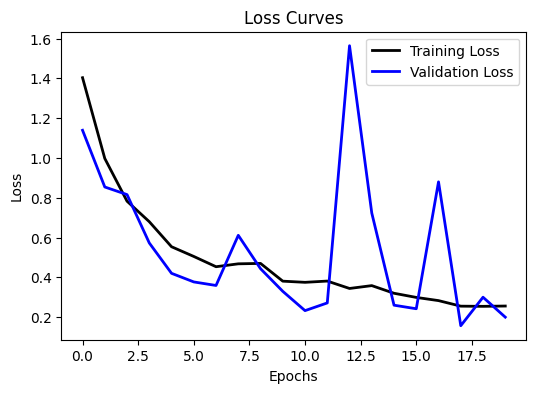

In [15]:
plt.figure(figsize=[6, 4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### 2.2 - Approach 2

We're still not using the pre-trained weights, however, in this approach, we're creating a feature extractor from the original ResNet-18 model.

- Creating a feature extractor:
    - We're keeping all layers of orig_model except the final classification layer. This is done by selecting all layers up to the last one and appending a Flatten layer to prepare the features for the linear layer.
    - The `nn.Sequential(*layers)` construct creates a new model (vec_model) that acts as a feature extractor.

- Freezing the parameters:
    - By setting `param.requires_grad = False` for all parameters in vec_model, we're freezing the weights of these layers during training. This means that the pre-trained weights of these layers (if any were loaded) will not be updated, reducing the number of parameters that need to be trained.

- Adding a new classification layer:
    - We then add a new `nn.Linear(512, 6)` layer to vec_model, adapting it to classify images into 6 categories. This layer is the only part of the model with trainable parameters in this setup.

- Effect on training:
    - **Reduced training time and computational cost:** Since most of the model parameters are frozen, the optimizer only needs to update the weights of the new classification layer.
    - **Leverages learned features:** The frozen layers act as a feature extractor, utilizing learned patterns from pre-existing tasks (if the original model was pre-trained). This can lead to faster convergence and potentially better performance on the new task, especially when the dataset is small or similar to the original task's dataset.
    - **Flexibility and fine-tuning:** This approach allows for quick experimentation with different architectures for the new task by only modifying the final layer(s). It's also a step towards more sophisticated fine-tuning strategies, where some of the frozen layers could be gradually unfrozen and trained to further improve performance.

In [16]:
# get all the layers except the last one
layers = list(orig_model.children())[:-1]
layers.append(nn.Flatten())

vec_model = nn.Sequential(*layers)
for param in vec_model.parameters():
    param.requires_grad = False

In [17]:
# now get all the layers except the last one
layers = list(vec_model.children())
layers.append(nn.Linear(512, 6))

vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        (9,408)
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        (128)
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-6                    [16, 64, 56, 56]  

In [18]:
model = vec_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

In [19]:
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):
    # Training 
    train_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # per step
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch, train_loss/len(trainloader), val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.6313178809483846 Val Loss: 1.5037292398904498
Epoch: 1 Train Loss: 1.4307905292510987 Val Loss: 1.3401421841822172
Epoch: 2 Train Loss: 1.3211739540100098 Val Loss: 1.2162592316928662
Epoch: 3 Train Loss: 1.2487905788421632 Val Loss: 1.1384938108293634
Epoch: 4 Train Loss: 1.1682857783635456 Val Loss: 1.0797595491534786
Epoch: 5 Train Loss: 1.1292112747828165 Val Loss: 1.0512733773181313
Epoch: 6 Train Loss: 1.083344625631968 Val Loss: 0.9959615563091478
Epoch: 7 Train Loss: 1.040751150449117 Val Loss: 0.9694464724314841
Epoch: 8 Train Loss: 1.0268239736557008 Val Loss: 0.917264638762725
Epoch: 9 Train Loss: 0.9977773276964823 Val Loss: 0.8902059699359693
Epoch: 10 Train Loss: 1.0032433517773947 Val Loss: 0.8685595612776907
Epoch: 11 Train Loss: 0.9731196928024292 Val Loss: 0.8575963315210844
Epoch: 12 Train Loss: 0.9443497165044149 Val Loss: 0.8225176930427551
Epoch: 13 Train Loss: 0.9363376720746358 Val Loss: 0.8042649814957067
Epoch: 14 Train Loss: 0.927259680

Text(0.5, 1.0, 'Loss Curves')

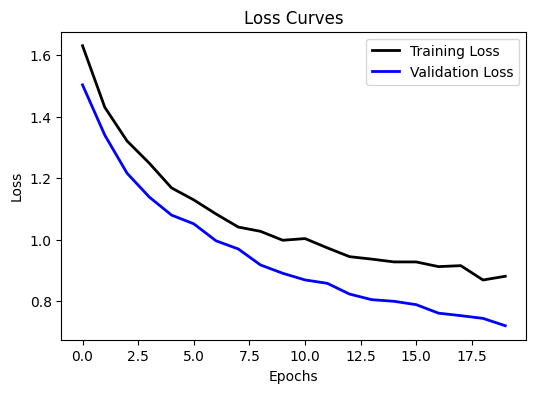

In [20]:
plt.figure(figsize=[6, 4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### 2.3 - Approach 3

In this third approach, we're implementing transfer learning with a twist by **utilizing the pre-trained weights of ResNet-18** and then adapting it for a new task with 6 classes.

- Starting with a pre-trained model:
    - The original ResNet-18 model is initialized with pre-trained weights from ImageNet (via `weights=models.ResNet18_Weights.IMAGENET1K_V1`). This provides the model with a strong knowledge base learned from a large and diverse dataset.

- Creating a customized model:
    - A fresh copy of the pre-trained ResNet-18 is made to preserve the original model's state. This ensures that any modifications are isolated to this new instance (alt_model).
    - The final fully connected (fc) layer of alt_model is replaced with a new `nn.Linear(512, 6)` layer, adapting the model to output predictions for 6 classes instead of the original 1000 ImageNet classes.

- Impact on training:
    - **Accelerated learning and improved performance:** Leveraging pre-trained weights can significantly speed up the training process and improve the model's performance on the new task, especially when the new dataset is small or similar to ImageNet.
    - **Fine-tuning for a new task:** This approach is essentially fine-tuning the pre-trained model for a new classification task. While the bulk of the model retains its learned features, the new final layer allows the model to learn how to classify inputs into the 6 new categories.
    - **Balancing between generalization and specialization:** This strategy strikes a balance between leveraging the generalization capabilities of the pre-trained model and specializing it for the specific requirements of the new task.

In [8]:
# let's make a fresh copy of the original model
orig_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512, 6)

In [12]:
model = alt_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

In [13]:
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):
    # Training 
    train_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # per step
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch, train_loss/len(trainloader), val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8619259377320607 Val Loss: 0.27597695510638387
Epoch: 1 Train Loss: 0.2624207325776418 Val Loss: 0.12434712807206731
Epoch: 2 Train Loss: 0.15928233506778877 Val Loss: 0.0665921955124328
Epoch: 3 Train Loss: 0.12252989222606023 Val Loss: 0.04524062169519694
Epoch: 4 Train Loss: 0.08745300057033698 Val Loss: 0.029038519047102647
Epoch: 5 Train Loss: 0.06225854141016801 Val Loss: 0.02398753403931072
Epoch: 6 Train Loss: 0.053368848251799744 Val Loss: 0.023198301989683194
Epoch: 7 Train Loss: 0.055177369775871433 Val Loss: 0.02223314695354355
Epoch: 8 Train Loss: 0.047786024572948615 Val Loss: 0.014283408190270788
Epoch: 9 Train Loss: 0.03667535645266374 Val Loss: 0.012109235670466564
Epoch: 10 Train Loss: 0.04028480091442665 Val Loss: 0.01845565163162782
Epoch: 11 Train Loss: 0.036192543506622314 Val Loss: 0.010525036707373434
Epoch: 12 Train Loss: 0.04062361104724308 Val Loss: 0.008914102267130818
Epoch: 13 Train Loss: 0.027668960988521576 Val Loss: 0.006333289208

Text(0.5, 1.0, 'Loss Curves')

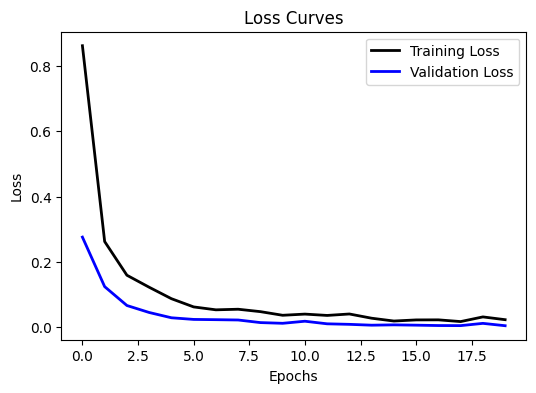

In [14]:
plt.figure(figsize=[6, 4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### 2.4 - Approach 4

Using a pre-trained ResNet-18 model as a feature extractor for a new task with 6 classes, while keeping the pre-trained weights intact but not training them. This method combines the principles of transfer learning with the feature extraction approach.

- Utilizing pre-trained ResNet-18 as a base:
    - The model starts with layers from the pre-trained ResNet-18, excluding the final classification layer. This initial setup leverages the rich feature extraction capabilities learned from ImageNet.

- Freezing the feature extractor layers:
    - All parameters in the feature extraction part (vec_model) are frozen `(requires_grad = False)`. This ensures that the pre-trained weights are preserved and not updated during the training process, focusing the learning on the new classification layer.

- Appending a new classification layer:
    - A new fully connected layer `(nn.Linear(512, 6))` is added to classify the features extracted by the pre-trained model into 6 classes. This is the only part of the model with trainable parameters.

- Effects on training and model performance:
    - **Efficient use of computational resources:** Freezing the pre-trained layers reduces the number of trainable parameters, speeding up the training process and decreasing computational costs.
    - **Quick adaptation to new tasks:** The model can quickly adapt to new classification tasks with minimal additional training, making it suitable for scenarios with limited data.
    - **Leveraging pre-learned features:** By using a pre-trained model as a feature extractor, the method exploits the generalization ability of these features, potentially leading to better performance on the new task compared to training from scratch.
    
**Scheduler:**

- Per Step (or Iteration):
    - When `scheduler.step()` is called after each training step (or iteration), the learning rate is adjusted at a finer granularity. This means the learning rate can change after every batch of data is processed.
    - This approach allows for more dynamic adjustments of the learning rate, potentially leading to faster convergence and better accommodation of the learning process nuances.
    
- Per Epoch:
    - Calling `scheduler.step()` after each epoch means the learning rate is adjusted once all batches in the dataset have been processed. An epoch completes when the model has been trained on every sample in the training dataset once.
    - This method is more coarse and applies more gradual changes to the learning rate.

In [9]:
# get all the layers except the last one
layers = list(orig_model.children())[:-1]
layers.append(nn.Flatten())

vec_model = nn.Sequential(*layers)
for param in vec_model.parameters():
    param.requires_grad = False

In [10]:
# get all the layers except the last one
layers = list(vec_model.children())
layers.append(nn.Linear(512,6))

vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        (9,408)
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        (128)
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-6                    [16, 64, 56, 56]  

In [14]:
model = vec_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

In [15]:
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):
    # Training 
    train_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # per epoch
    scheduler.step()
    
    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch, train_loss/len(trainloader), val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8706312934557597 Val Loss: 0.2895471563464717
Epoch: 1 Train Loss: 0.3173775056997935 Val Loss: 0.14799009283122264
Epoch: 2 Train Loss: 0.2503130920728048 Val Loss: 0.12428985830200345
Epoch: 3 Train Loss: 0.20123011688391368 Val Loss: 0.09814762843674735
Epoch: 4 Train Loss: 0.1693988532324632 Val Loss: 0.09607138416092646
Epoch: 5 Train Loss: 0.15563527531921864 Val Loss: 0.08245408873220808
Epoch: 6 Train Loss: 0.1313462385038535 Val Loss: 0.070365754152207
Epoch: 7 Train Loss: 0.13242210102578003 Val Loss: 0.07015010131228912
Epoch: 8 Train Loss: 0.12988864928483962 Val Loss: 0.06491241084509775
Epoch: 9 Train Loss: 0.13059402445952098 Val Loss: 0.06394948727010112
Epoch: 10 Train Loss: 0.12142405825356642 Val Loss: 0.06367796345760948
Epoch: 11 Train Loss: 0.11538417935371399 Val Loss: 0.06161455908103993
Epoch: 12 Train Loss: 0.14151105135679246 Val Loss: 0.05916367662384322
Epoch: 13 Train Loss: 0.1064505667736133 Val Loss: 0.05693798247528704
Epoch: 14 T

Text(0.5, 1.0, 'Loss Curves')

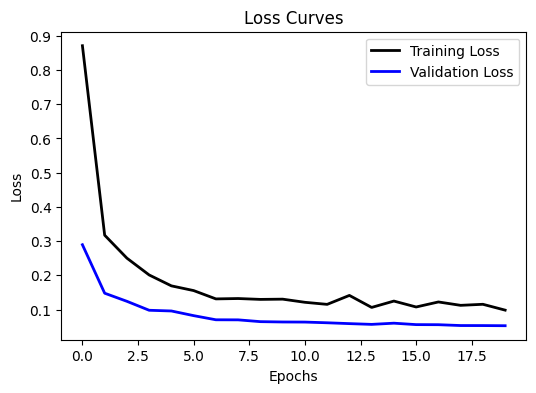

In [16]:
plt.figure(figsize=[6, 4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [17]:
torch.save(model.state_dict(), './models/tl_resnet.pth')

<font color="purple">Now, replace `resnet18` with `alexnet` and repeat the training</font>

In [25]:
orig_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [16, 1000]                --
+ Sequential: 1-1                        [16, 256, 6, 6]           --
|    + Conv2d: 2-1                       [16, 64, 55, 55]          23,296
|    + ReLU: 2-2                         [16, 64, 55, 55]          --
|    + MaxPool2d: 2-3                    [16, 64, 27, 27]          --
|    + Conv2d: 2-4                       [16, 192, 27, 27]         307,392
|    + ReLU: 2-5                         [16, 192, 27, 27]         --
|    + MaxPool2d: 2-6                    [16, 192, 13, 13]         --
|    + Conv2d: 2-7                       [16, 384, 13, 13]         663,936
|    + ReLU: 2-8                         [16, 384, 13, 13]         --
|    + Conv2d: 2-9                       [16, 256, 13, 13]         884,992
|    + ReLU: 2-10                        [16, 256, 13, 13]         --
|    + Conv2d: 2-11                      [16, 256, 13, 13]        

### Approach 1

- use pre-trained weights 
- not using a feature

In [26]:
# Create a deepcopy of the original model replacing the final layer for 6-classes instead of 1000
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

model = alt_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

In [27]:
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):
    
    # Training 
    train_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # per step
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch, train_loss/len(trainloader), val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.0058143773302435 Val Loss: 0.10622034381192766
Epoch: 1 Train Loss: 0.08766043577343226 Val Loss: 0.04872285422721976
Epoch: 2 Train Loss: 0.08529014995321632 Val Loss: 0.07784946141213081
Epoch: 3 Train Loss: 0.04686861799408992 Val Loss: 0.029312997122791496
Epoch: 4 Train Loss: 0.02049825112645825 Val Loss: 0.044608854973902407
Epoch: 5 Train Loss: 0.01515666080522351 Val Loss: 0.01632363009404894
Epoch: 6 Train Loss: 0.009508194255953034 Val Loss: 0.017415325489549247
Epoch: 7 Train Loss: 0.006025125132194565 Val Loss: 0.013781076720509813
Epoch: 8 Train Loss: 0.0078194746763135 Val Loss: 0.02454400452973603
Epoch: 9 Train Loss: 0.008805146805486098 Val Loss: 0.017077549688493537
Epoch: 10 Train Loss: 0.015155909536406397 Val Loss: 0.04395016032829421
Epoch: 11 Train Loss: 0.020594812176811198 Val Loss: 0.018513427802980386
Epoch: 12 Train Loss: 0.003454488397789343 Val Loss: 0.011749398610510596
Epoch: 13 Train Loss: 0.0021315930378235258 Val Loss: 0.0162497

Text(0.5, 1.0, 'Loss Curves')

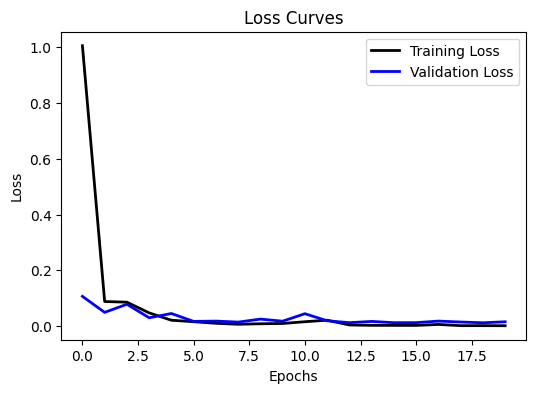

In [28]:
plt.figure(figsize=[6, 4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### Approach 2
- use pre-trained weights
- create a feature extractor

In [31]:
# get all the layers except the classifier
layers = list(orig_model.features)
layers.append(nn.Flatten()) # flatten the output of the convolutional layers

# freeze parameters in the feature extractor
for param in orig_model.parameters():
    param.requires_grad = False
    
# Note: AlexNet's feature vector size is 256*6*6 after flattening when the input is 224x224
layers.append(nn.Linear(256*6*6, 6)) # append new classifier

# Create the new model
vec_model = nn.Sequential(*layers)
model = vec_model.to(device)

summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 55, 55]          (23,296)
+ ReLU: 1-2                              [16, 64, 55, 55]          --
+ MaxPool2d: 1-3                         [16, 64, 27, 27]          --
+ Conv2d: 1-4                            [16, 192, 27, 27]         (307,392)
+ ReLU: 1-5                              [16, 192, 27, 27]         --
+ MaxPool2d: 1-6                         [16, 192, 13, 13]         --
+ Conv2d: 1-7                            [16, 384, 13, 13]         (663,936)
+ ReLU: 1-8                              [16, 384, 13, 13]         --
+ Conv2d: 1-9                            [16, 256, 13, 13]         (884,992)
+ ReLU: 1-10                             [16, 256, 13, 13]         --
+ Conv2d: 1-11                           [16, 256, 13, 13]         (590,080)
+ ReLU: 1-12                             [16, 256, 

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

In [33]:
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):
    
    # Training 
    train_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # per step
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch, train_loss/len(trainloader), val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.45278219431638717 Val Loss: 0.17827714028719224
Epoch: 1 Train Loss: 0.13249883939822515 Val Loss: 0.11067480574312963
Epoch: 2 Train Loss: 0.09186411122481028 Val Loss: 0.08981953811292585
Epoch: 3 Train Loss: 0.07247208972771962 Val Loss: 0.07266771994335086
Epoch: 4 Train Loss: 0.058772495624919735 Val Loss: 0.06333426582185846
Epoch: 5 Train Loss: 0.05051117796450853 Val Loss: 0.059401900801611576
Epoch: 6 Train Loss: 0.044622983150184155 Val Loss: 0.053538992902950236
Epoch: 7 Train Loss: 0.039953430083890754 Val Loss: 0.049981442084045785
Epoch: 8 Train Loss: 0.035761762969195844 Val Loss: 0.04692149784808096
Epoch: 9 Train Loss: 0.032892584651708606 Val Loss: 0.04462025971396973
Epoch: 10 Train Loss: 0.03055022389938434 Val Loss: 0.042590403782301826
Epoch: 11 Train Loss: 0.028054327772309384 Val Loss: 0.041022573646746184
Epoch: 12 Train Loss: 0.02612361258516709 Val Loss: 0.03883642425123406
Epoch: 13 Train Loss: 0.0247371177872022 Val Loss: 0.0377744630

Text(0.5, 1.0, 'Loss Curves')

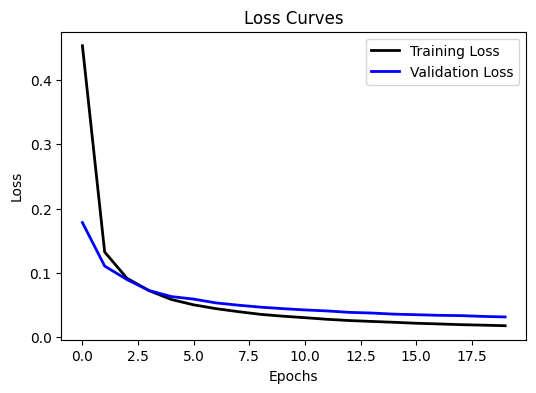

In [34]:
plt.figure(figsize=[6, 4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### References
- [Nepture.ai](https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras)
- [Towards Data Science](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)